This is how I implemented what's introduced in Xiong et al. (2017). While this does an exhausitve review on different entropy measures, equations in the article are not fully explained. I tried to implement ideas as much as I can.

Full disclosure - I wrote the code with the help of ChatGPT.

# Sample time series generation

An AR(2) series: $\phi_1$ = 0.4, $\phi_2$ = -0.3, $\sigma$ = 1, N=100

In [1]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt

# Step 1. Create a time series: AR(2)
def generate_time_series(phi1: float,
                         phi2: float,
                         sigma: float,
                         n: int,
                         seed: int=42) -> np.ndarray:
    """
    Generates a synthetic AR(2) time series.

    Parameters:
    phi1 (float): AR coefficient for lag 1.
    phi2 (float): AR coefficient for lag 2.
    sigma (float): Standard deviation of noise.
    n (int): Length of the time series.
    seed (int): Random seed for reproducibility.

    Returns:
    np.ndarray: The generated time series.
    """
    np.random.seed(seed)
    epsilon = np.random.normal(0, sigma, n) # noise
    ts = np.zeros(n)  # Preallocate the time series array
    for t in range(2, n):
      ts[t] = phi1 * ts[t-1] + phi2 * ts[t-2] + epsilon[t]
    return ts

# AR(2) parameters
PHI1 = 0.4
PHI2 = -0.3
SIGMA = 1   # Standard deviation of the white noise
N_TS = 100  # Length of the time series

my_ts = generate_time_series(PHI1, PHI2, SIGMA, N_TS)

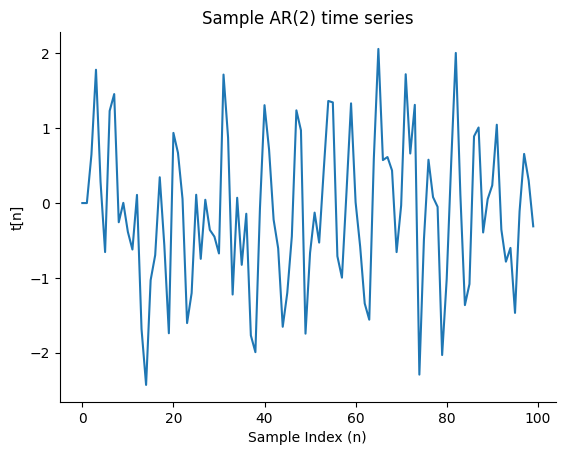

In [2]:
# @title
fig, ax = plt.subplots()
ax.plot(my_ts)
ax.set_xlabel('Sample Index (n)')
ax.set_ylabel('t[n]')
ax.set_title('Sample AR(2) time series')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.show()

# Difference calculation: Chebyshev distance

`chebyshev_distance` implements the calculation of Chebyshev distance defined as $d_{chebyshev}(x, y) := \max_{1 \le i \le n}|x_i - y_i|$. In fact, it is already implemented as `scipy.spatial.distance.chebyshev(u, v)`.

In [3]:
def chebyshev_distance(x, y):
    return np.max(np.abs(x - y))

# Kernel function: Heaviside function

`my_heaviside` implements the Heaviside function (𝚯) with radius `r`.

$$
𝚯(x) = \begin{cases}
  1, & x \le r\\    
  0, & x \gt r    
\end{cases}
$$

In [4]:
# Implementing the kernel
def heaviside_kernel(x: float, r: float) -> int:
  """
  Heaviside step function for threshold comparison.

  Parameters:
  x (float): Input value.
  r (float): Threshold value.

  Returns:
  int: 1 if x <= r, else 0.
  """
  return 1 if x <= r else 0

# Kernel Density Estimation
The next step was to write a function that calculates the kernel density estimate (ex. $p(x_n)$, $p(x_n^m)$, $p(x_n, x_n^m)$).

I am making it so that it would disregard self-match (i.e. a template is similar to itself). This was to make sure that I get the same conditional entropy, $C(X)$, as a published implementation's output. I used `antropy`[https://github.com/raphaelvallat/antropy] to test it.

In [5]:
def calculate_kernel_density(x_series: list|np.ndarray,
                             r: float,
                             m: int=1) -> np.ndarray:
    """
    Estimate the probability density p(x_n), p(x_n^m),
    or p(x_n, x_n^m) using kernel density estimation.

    Parameters:
        x_series (ndarray): Time series data (length N).
        r (float): Radius for the Heaviside kernel.
        m (int, default=1): embedding dimension

    Returns:
        ndarray: p(x_n), p(x_n^m), or p(x_n, x_n^m).
    """
    N = len(x_series)
    # Because Python starts from 0...
    mprime = m - 1
    p = np.zeros(N-mprime)
    # modified from `for n in range(N):`
    for n in range(N-mprime):
        x_n = x_series[n:n+mprime+1]
        for i in range(N-mprime):
            # Let's not count self-match
            if i != n:
                distance = chebyshev_distance(x_n,
                                              x_series[i:i+mprime+1])
                # modified from `p[n] += ...`
                p[n] += heaviside_kernel(distance, r)
        p[n] /= (N - mprime - 1)
    return p

# Ensemble average

I prepare a function to calculat the ensemble average, $\langle\ . \rangle$.

In [6]:
def calculate_ensemble_average(x_series: list|np.ndarray,
                               r: float,
                               m: int=1) -> float:
    """
    Calculate the ensemble average <.>.

    Parameters:
        x_series (ndarray): Time series data (length N).
        r (float): Radius for the Heaviside kernel.
        m (int, default=1): embedding dimension

    Returns:
        float: The ensemble average <.>.
    """
    p_x = calculate_kernel_density(x_series, r=r, m=m)
    return np.mean(p_x)

# Interim check: kernel density estimation

I create a toy example and check if kernel density estimates are correct.

In [7]:
# Toy example
aseries = np.array([1.0, -1.0, 0.0, 1.0, 1.1, 2.0])
# σ(aseries) ~= 0.949415
tol = np.std(aseries)
print(f'std of the array is {tol}')
# p(x_n), n \in {1,2,3,4,5}
p = calculate_kernel_density(aseries, tol)
# [0.4, 0, 0, 0.4, 0.6, 0.2]
print(f'kernel density estimate: {p}')

std of the array is 0.9494150245750743
kernel density estimate: [0.4 0.  0.  0.4 0.6 0.2]


So for the first item of `aseries`(1), distances ($d_i$; no self-match) will be:
   
1.   $d_1 = |1-(-1)| = 2$
2.   $d_2 = |1-0| = 1$
3.   $d_3 = |1-1| = 0$
4.   $d_4 = |1-1.1| = 0.1$
5.   $d_5 = |1-2| = 1$

𝚯($d_i$, $r$) is 1 if $d_i \le r$ else 0
($r = 0.949415$)

1.   𝚯($d_1, r) = 0 \ (2 \gt 0.949415)$
2.   𝚯($d_2, r) = 0 \ (1 \gt 0.949415)$
3.   𝚯($d_3, r) = 0 \ (0 \le 0.949415)$
4.   𝚯($d_4, r) = 1 \ (0.1 \le 0.949415)$
5.   𝚯($d_5, r) = 0 \ (1 \gt 0.949415)$
  
So $p(x_1) = (0+0+1+1+0)/5 = 2/5 = 0.4$

In [8]:
# Shall we try m=2?
# p(x_n^2) // x_n^2 = (x_{n-1}, x_{n-2})
pofm2 = calculate_kernel_density(aseries, tol, m=2)
# [0, 0, 0, 0.25, 0.25]
print(f'With m=2, kernel density estimate is {pofm2}')

With m=2, kernel density estimate is [0.   0.   0.   0.25 0.25]


So for the first length 2 vector of `aseries`, (1, -1),
aseries = np.array([1, -1, 0, 1, 1.1, 2])
distances ($d_i$; no self-match) will be:
1.   $d_1 = \max(|1-(-1)|, |-1-0|) = 2$
2.   $d_2 = \max(|1-0|, |-1-1|) = 2$
3.   $d_3 = \max(|1-1|, |-1-1.1|) = 2.1$
4.   $d_4 = \max(|1-1.1|, |-1-2|) = 3$

These distances will make heaviside function returns ALL zeros. Thus $p(x_1) = 0$.

# Conditional Entropy: $C(X)$

In [9]:
def calculate_conditional_entropy(xseries: np.ndarray,
                             r: float,
                             m: int=1) -> float:
    """
    C(X) = H(X_n|X_n^m)
         = -ln <p(x_n, x_n^m)>/<p(x_n^m)>

    This function should return Sample Entropy (SampEn)
    because self-match is not considered.

    Parameters:
        xseries (ndarray): Time series data (length N).
        r (float): Radius for the Heaviside kernel.
        m (int, default=1): embedding dimension.

    Returns:
        float: conditional entropy (SampEn)
    """
    ensemble_joint = calculate_ensemble_average(xseries, r, m+1)

    ensemble_marg = calculate_ensemble_average(xseries[:-1], r, m)

    return -np.log(ensemble_joint/ensemble_marg)

# Entropy: $E(X)$

In [10]:
def calculate_entropy(xseries: np.ndarray,
                      r: float,
                      m: int=1) -> float:
    """
    E(X) = H(X_n) = -ln <p(x_n)>

    Parameters:
        xseries (ndarray): Time series data (length N).
        r (float): Radius for the Heaviside kernel.
        m (int, default=1): embedding dimension.

    Returns:
        float: entropy
    """
    return -np.log(calculate_ensemble_average(xseries[m:], r))

# Information Storage: $S(X)$

In [11]:
def calculate_information_storage(xseries: np.ndarray,
                                  r: float,
                                  m: int=1) -> float:
    """
    S(X) = I(X_n;X_n^m)
         = ln <p(x_n, x_n^m)>/<p(x_n)*p(x_n^m)>

    Parameters:
        xseries (ndarray): Time series data (length N).
        r (float): Radius for the Heaviside kernel.
        m (int, default=1): embedding dimension.

    Returns:
        float: information storage
    """
    ensemble_joint = calculate_ensemble_average(xseries, r, m+1)
    p_x_n = calculate_kernel_density(xseries[m:], r)
    p_x_n_m = calculate_kernel_density(xseries[:-1], r, m)
    ensemble_marginals = np.mean(
            [p1*p2 for p1, p2 in zip(p_x_n, p_x_n_m)])

    return np.log(ensemble_joint / ensemble_marginals)

# Testing if $C(X)$ is the same as a published package's result

I compare my implementation of $C(X)$ to `antropy.sample_entropy`.

In [12]:
!pip install antropy

In [13]:
from antropy import sample_entropy
# calculate C(X), my implementation
tol = 0.25*np.std(my_ts)
my_sampen = calculate_conditional_entropy(my_ts, r=tol, m=2)
print(f'My SampEn: {my_sampen:.6f}')

# Calculate SampEn, using `antropy` package
# https://github.com/raphaelvallat/antropy
algorithmic = sample_entropy(my_ts, tolerance=tol)
print(f'Algorithmic SampEn: {algorithmic:.6f}')

# The two are 'close'
print(f'Are the estimates close? {np.isclose(my_sampen, algorithmic)}')

My SampEn: 2.410799
Algorithmic SampEn: 2.410799
Are the estimates close? True


Doing a more _systematic_ comparison here.

In [14]:
from collections import defaultdict
rs = [0.2, 0.25, 0.3]
ms = [2, 3]

my_sampens = defaultdict(list)
algorithms = defaultdict(list)

for m in ms:
  for r in rs:
    tol = r * np.std(my_ts)
    my_sampens[m].append(calculate_conditional_entropy(my_ts, tol, m))
    algorithms[m].append(sample_entropy(my_ts, order=m, tolerance=tol))

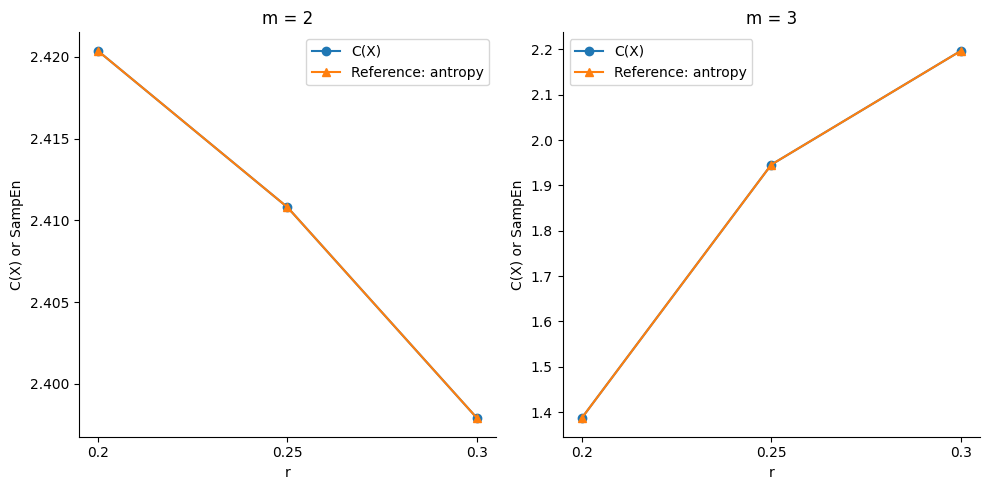

In [15]:
# @title
fig, axes = plt.subplots(1,2, figsize=(10, 5))
for iax, ax in enumerate(axes):
  ax.plot(my_sampens[iax+2], label='C(X)', marker='o')
  ax.plot(algorithms[iax+2], label='Reference: antropy', marker='^')
  ax.set_xticks((0,1,2), ['0.2', '0.25', '0.3'])
  ax.set_xlabel('r')
  ax.set_ylabel('C(X) or SampEn')
  ax.set_title(f'm = {iax+2}')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.yaxis.set_ticks_position('left')
  ax.xaxis.set_ticks_position('bottom')
  ax.legend()
plt.tight_layout()
plt.show()

My $C(X)$ well aligns with a reference value for different combinations of ($m, r$).

# E(X) = S(X) + C(X)?

Numerically, this is not so true. I may be missing something... or it's just an inherent limitation.

In [16]:
# Check the relationship: E(X) = S(X) + C(X)
# tol = 0.3 * np.std(my_ts)
C_X = calculate_conditional_entropy(my_ts, tol, 2)
E_X = calculate_entropy(my_ts, tol, 2)
S_X = calculate_information_storage(my_ts, tol, 2)
print(f"C[X]: {C_X}")
print(f"E[X]: {E_X}")
print(f"S[X]: {S_X}")
print(f"Relationship holds? {np.isclose(E_X, C_X+S_X)}")

C[X]: 2.3978952727983707
E[X]: 1.870750762652698
S[X]: -0.5354679459291346
Relationship holds? False
